In [ ]:
!pip install biopython
!pip install aaindex

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn.metrics as skl
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParamData
from aaindex import aaindex1
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix

# **Features extraction**



In [ ]:
# Import the training set
complete_train = pd.read_csv("complete_train.tsv", sep='\t', names = ['id', 'organism_name', 'kingdom', 'sequence_length', 'signal_peptide', 'validation_n', 'sp_type', 'sequence'])
complete_train.head()

,id,organism_name,kingdom,sequence_length,signal_peptide,validation_n,sp_type,sequence
0,Q99MA2,Rattus norvegicus,Metazoa,674,22,3,1,MAQAYWQCYPWLVLLCACAWSYPGPESLGREDVRDCSTNPPRLPVT...
1,P17948,Homo sapiens,Metazoa,1338,26,1,1,MVSYWDTGVLLCALLSCLLLTGSSSGSKLKDPELSLKGTQHIMQAG...
2,P41271,Homo sapiens,Metazoa,181,16,1,1,MMLRVLVGAVLPAMLLAAPPPINKLALFPDKSAWCEAKNITQIVGH...
3,Q8I948,Acanthoscurria gomesiana,Metazoa,156,23,4,1,MAFRMKLVVCIVLLSTLAVMSSADVYKGGGGGRYGGGRYGGGGGYG...
4,Q92154,Coturnix japonica,Metazoa,620,17,4,1,MELLVLTVLLMGTGCISAPWAAWMPPKMAALSGTCVQLPCRFDYPE...


In [ ]:
# Assign a numeric index to each aminoacid
order = list("ARNDCQEGHILKMFPSTWYV")
aa_index = {}
for i, aa in enumerate(order):
  aa_index[aa]= i
print(aa_index)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


In [ ]:
def aa_composition(sequence, length: int, aa_index):
  ''' Calculate the aminoacid frequency of a sequence of a given length
  '''
  sequence = sequence[:length]
  freq = np.zeros((1, 20))
  for aa in sequence:
    if aa in aa_index.keys():
      freq[0, aa_index[aa]] += 1
  freq = np.round(freq/len(sequence), 3)
  return freq

# Calculate the aminoacid composition for each sequence of the dataframe and save it into a unique numpy matrix
aa_comp = np.vstack(complete_train['sequence'].apply(aa_composition, args=(22, aa_index)))
aa_comp

array([[0.182, 0.   , 0.   , ..., 0.136, 0.136, 0.045],
       [0.045, 0.   , 0.   , ..., 0.045, 0.045, 0.091],
       [0.182, 0.045, 0.   , ..., 0.   , 0.   , 0.136],
       ...,
       [0.091, 0.   , 0.045, ..., 0.   , 0.   , 0.045],
       [0.   , 0.136, 0.045, ..., 0.   , 0.   , 0.136],
       [0.045, 0.091, 0.   , ..., 0.   , 0.   , 0.136]])

In [ ]:
def hydrophobicity(sequence, window: int, length: int):
  ''' Calculates the hydrophobicity of each residue considering the context given by sliding window of adiacent aminoacids
  '''
  sequence = sequence[:length]
  seq = ProteinAnalysis(sequence)
  kd_pos = seq.protein_scale(ProtParamData.kd,window)
  d = int(window/2)
  sequence_with_padding = "X"*d + sequence + "X"*d
  seq_padding = ProteinAnalysis(sequence_with_padding)
  kd_pos_with_padding = seq_padding.protein_scale(ProtParamData.kd, window)
  return kd_pos_with_padding

# Calculate the hydrophobicity of the first 40 residues for each sequence and save it into a unique matrix numpy
hydro = np.vstack(complete_train['sequence'].apply(hydrophobicity, args=(5,40)))

Output streaming troncato alle ultime 5000 righe.


In [ ]:
feature_codes = {
    "net_charge": ("KLEP840101", 2),
    "hydrophilicity": ("HOPT810101", 5),
    "helix_propensity": ("CHAM830101",7),
    "flexibility": ("BHAR880101", 7),
    "isoelectric_point": ("ZIMJ680104", 2),
    "bulkiness": ("ZIMJ680102", 7)
}

def features(sequence, length: int, feature_code, window: int):
  ''' Creates an array of 3 values corresponding to mean, standard deviation,
      and maximum value of a given dictionary of features
  '''
  sequence = sequence[:length]
  seq = ProteinAnalysis(sequence)
  vals = aaindex1[feature_code].values
  val = seq.protein_scale(vals,window)
  mean = np.mean(val)
  std = np.std(val)
  max = np.max(val)
  return np.round([mean, std, max], 3)

feats = {}
for feature in feature_codes.keys():
  feats[feature] = np.vstack(complete_train['sequence'].apply(features, args=(30, feature_codes[feature][0], feature_codes[feature][1])))

# Create the
np.savez('separate_features.npz', aa_comp = aa_comp, hydrophobicity = hydro, **feats)

In [ ]:
extracted_features = np.load("separate_features.npz")
# Create a dictionary from the loaded features, handling multi-dimensional arrays
data = {}
for key in extracted_features.files:
    arr = extracted_features[key]
    if arr.ndim > 1:
        # If the array is multi-dimensional, create multiple columns
        for i in range(arr.shape[1]):
            data[f'{key}_{i+1}'] = arr[:, i]
    else:
        # If the array is 1-dimensional, use it directly
        data[key] = arr

X = pd.DataFrame(data)

In [ ]:
X["id"] = complete_train["id"]
X["validation_n"] = complete_train["validation_n"]
y = complete_train["sp_type"]
X.head()


,aa_comp_1,aa_comp_2,aa_comp_3,aa_comp_4,aa_comp_5,aa_comp_6,aa_comp_7,aa_comp_8,aa_comp_9,aa_comp_10,...,flexibility_2,flexibility_3,isoelectric_point_1,isoelectric_point_2,isoelectric_point_3,bulkiness_1,bulkiness_2,bulkiness_3,id,validation_n
0,0.182,0.000,0.0,0.000,0.136,0.091,0.000,0.000,0.0,0.000,...,0.046,0.499,5.844,0.744,9.163,15.949,2.369,20.414,Q99MA2,3
1,0.045,0.000,0.0,0.045,0.091,0.000,0.000,0.091,0.0,0.000,...,0.043,0.512,5.919,0.862,8.487,14.830,2.777,18.876,P17948,1
2,0.182,0.045,0.0,0.000,0.000,0.000,0.000,0.045,0.0,0.045,...,0.029,0.469,6.202,0.890,9.167,16.859,0.937,18.960,P41271,1
3,0.091,0.045,0.0,0.000,0.045,0.000,0.000,0.000,0.0,0.045,...,0.027,0.488,6.171,1.044,9.000,16.351,2.594,20.339,Q8I948,4
4,0.136,0.000,0.0,0.000,0.045,0.000,0.045,0.091,0.0,0.045,...,0.026,0.458,5.952,0.680,8.593,16.017,2.508,20.644,Q92154,4


# **Feature selection with RFE (Recursive Feature Elimination) and model training with SVM (Support Vector Machine)**

For each cross-validation fold made with different combination of train, validation and test sets:
*  Train an SVM baseline on all features.
*  Rank features by importance using a Random Forest.
*  Determine the optimal number of top features (k) using validation accuracy curves.
*  Retrain an SVM using only the top-k features.
*  Compare test accuracy with and without feature selection.
*  Save all datasets (.npz), plots, and results to allow reproducibility.

In [ ]:
def make_groups():
    l = [_ for _ in range(5)]
    group = {}
    for i in l:
        print(f'{(i%5)+1} {((i+1)%5)+1} {((i+2)%5)+1} {((i+3)%5)+1} {((i+4)%5)+1}')
        train = (((i%5)+1 ,((i+1)%5)+1 ,((i+2)%5)+1))
        test = ((i+3)%5)+1
        cross_val = ((i+4)%5)+1
        name_test = f'test_{i+1}'
        group[name_test] = (train, test, cross_val)
    return group

groups = make_groups()

1 2 3 4 5
2 3 4 5 1
3 4 5 1 2
4 5 1 2 3
5 1 2 3 4


dict_items([('test_1', ((1, 2, 3), 4, 5)), ('test_2', ((2, 3, 4), 5, 1)), ('test_3', ((3, 4, 5), 1, 2)), ('test_4', ((4, 5, 1), 2, 3)), ('test_5', ((5, 1, 2), 3, 4))])

In [ ]:
def svm_pipeline(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=42))
    ])

def accuracy_on_subset(C, gamma, subset_features):
    # subset by feature names
    # Convert data keys to a NumPy array for use with np.where
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in subset_features]
    Xtr = X_train.iloc[:, idx]
    Xva = X_val.iloc[:, idx]
    pipe = svm_pipeline(C, gamma)
    pipe.fit(Xtr, y_train)     # train on TRAIN only
    return pipe.score(Xva, y_val)  # accuracy on VALIDATION


def metrics(obs_test, y_pred_test):
  MCC = skl.matthews_corrcoef(obs_test, y_pred_test)            # Matthews Correlation Coefficient
  ACC = skl.accuracy_score(obs_test, y_pred_test)               # Accuracy
  PPV = skl.precision_score(obs_test, y_pred_test)              # Precision
  SEN = skl.recall_score(obs_test, y_pred_test)                 # Recall
  CONF =skl.confusion_matrix(obs_test , y_pred_test)            # Confusion Matrix
  return MCC, ACC, PPV, SEN, CONF

In [23]:
def grid_search(C_grid, gamma_grid, X_train, Y_train, X_val, Y_val):
    best_score = -np.inf
    best_params = None

    for C in C_grid:
        for gamma in gamma_grid:
            pipe = svm_pipeline(C, gamma)
            pipe.fit(X_train, Y_train)           # <-- niente .to_numpy()
            val_acc = pipe.score(X_val, Y_val)   # <-- niente .to_numpy()
            if val_acc > best_score:
                best_score = val_acc
                best_params = {"C": C, "gamma": gamma}

    return best_score, best_params


=== TEST_1 ===
Train: (1, 2, 3), Val: 4, Test: 5
0.978 with params {'C': 1.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0   hydrophilicity_1    0.088525
1  hydrophobicity_12    0.065966
2  hydrophobicity_10    0.057519
3  hydrophobicity_11    0.053042
4  hydrophobicity_13    0.051843
5        bulkiness_3    0.051351
6      flexibility_1    0.043066
7         aa_comp_11    0.042454
8   hydrophobicity_9    0.041239
9   hydrophobicity_8    0.035510


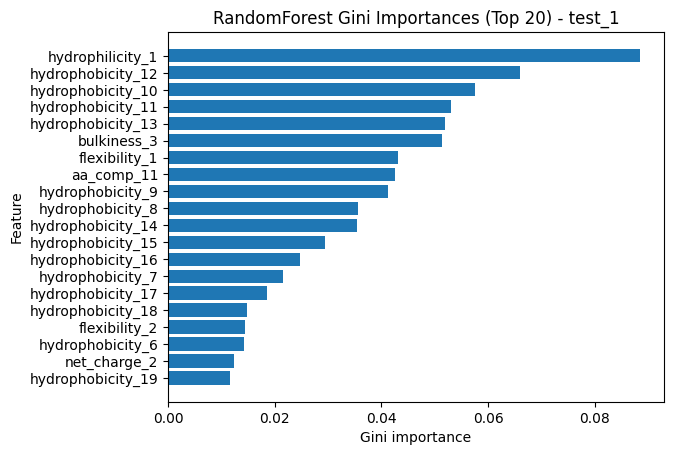

Best k on validation (using baseline best params): k=22, val_acc=0.975


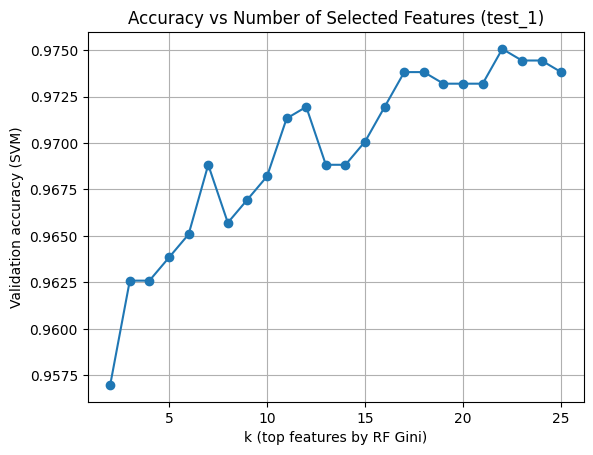


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.976
   → Found with parameters: C = 1.0, gamma = 0.1

Final test accuracy (using selected features): 0.970
Final test accuracy (using all features - baseline model): 0.976

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.849 | ACC = 0.970 | PPV = 0.847 | SEN = 0.886
Confusion Matrix:
 [[1402   28]
 [  20  155]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.881 | ACC = 0.976 | PPV = 0.854 | SEN = 0.937
Confusion Matrix:
 [[1402   28]
 [  11  164]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.849370  0.970093  0.846995  0.885714
1       All features  0.881254  0.975701  0.854167  0.937143

=== TEST_2 ===
Train: (2, 3, 4), Val: 5, Test: 1
0.977 with params {'C': 10.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0   hydrophilicity_1    0.082470
1  hydroph

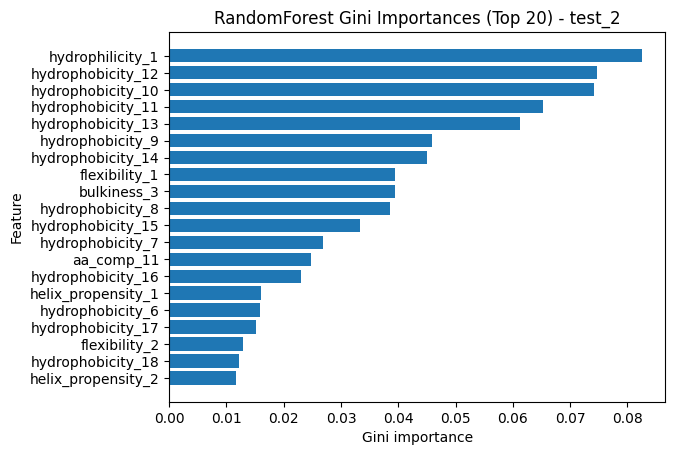

Best k on validation (using baseline best params): k=13, val_acc=0.966


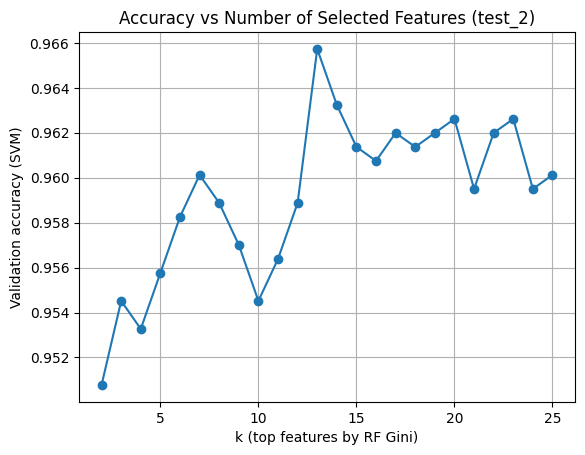


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.966
   → Found with parameters: C = 10.0, gamma = scale

Final test accuracy (using selected features): 0.959
Final test accuracy (using all features - baseline model): 0.971

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.789 | ACC = 0.959 | PPV = 0.808 | SEN = 0.817
Confusion Matrix:
 [[1396   34]
 [  32  143]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.852 | ACC = 0.971 | PPV = 0.873 | SEN = 0.863
Confusion Matrix:
 [[1408   22]
 [  24  151]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.789424  0.958879  0.807910  0.817143
1       All features  0.851762  0.971340  0.872832  0.862857

=== TEST_3 ===
Train: (3, 4, 5), Val: 1, Test: 2
0.973 with params {'C': 1.0, 'gamma': 0.01}
Top 10 features by Gini importance:
             feature  importance
0  hydrophobicity_11    0.082879
1  hydropho

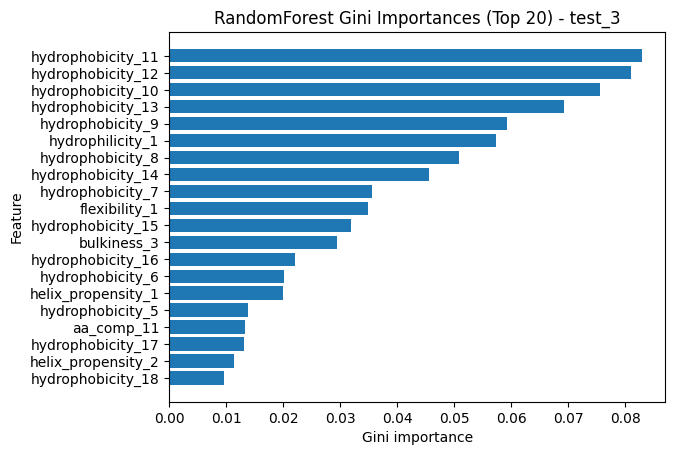

Best k on validation (using baseline best params): k=25, val_acc=0.967


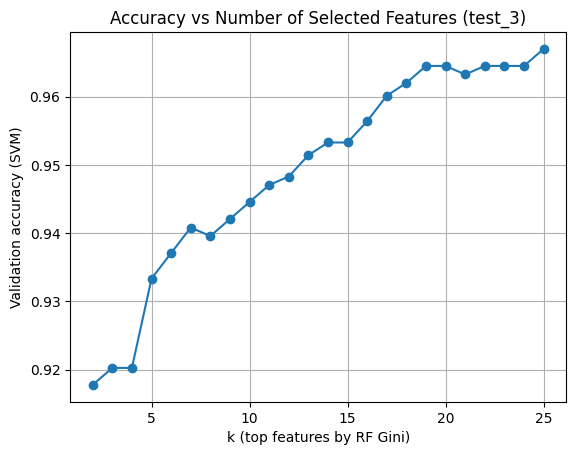


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.968
   → Found with parameters: C = 10.0, gamma = scale

Final test accuracy (using selected features): 0.968
Final test accuracy (using all features - baseline model): 0.968

 The model with feature selection performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.829 | ACC = 0.968 | PPV = 0.903 | SEN = 0.794
Confusion Matrix:
 [[1414   15]
 [  36  139]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.825 | ACC = 0.968 | PPV = 0.913 | SEN = 0.777
Confusion Matrix:
 [[1416   13]
 [  39  136]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.829449  0.968204  0.902597  0.794286
1       All features  0.824893  0.967581  0.912752  0.777143

=== TEST_4 ===
Train: (4, 5, 1), Val: 2, Test: 3
0.973 with params {'C': 10.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0  hydrophobicity_10    0.085224
1  hydro

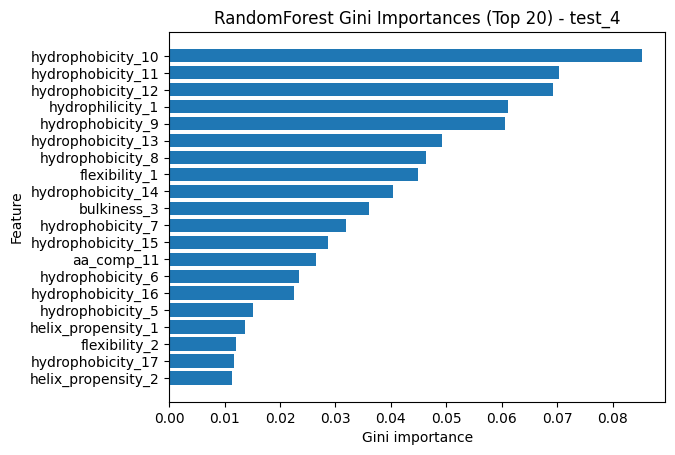

Best k on validation (using baseline best params): k=24, val_acc=0.969


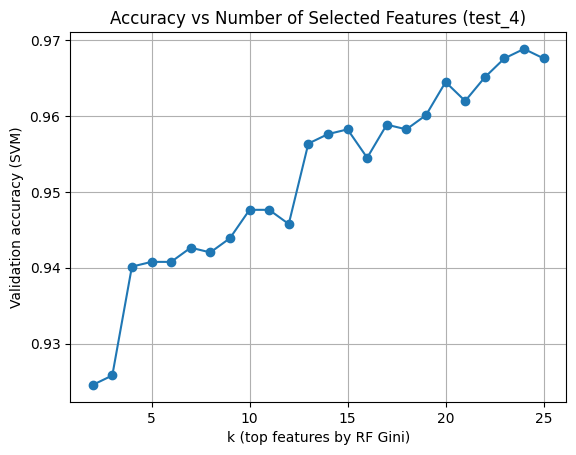


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.969
   → Found with parameters: C = 1.0, gamma = scale

Final test accuracy (using selected features): 0.973
Final test accuracy (using all features - baseline model): 0.973

 The model with selected features performs the same as the baseline.

=== SVM with FEATURE SELECTION ===
MCC = 0.860 | ACC = 0.973 | PPV = 0.888 | SEN = 0.862
Confusion Matrix:
 [[1410   19]
 [  24  150]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.858 | ACC = 0.973 | PPV = 0.902 | SEN = 0.845
Confusion Matrix:
 [[1413   16]
 [  27  147]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.859734  0.973175  0.887574  0.862069
1       All features  0.858004  0.973175  0.901840  0.844828

=== TEST_5 ===
Train: (5, 1, 2), Val: 3, Test: 4
0.976 with params {'C': 1.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0   hydrophilicity_1    0.075967
1  hydrophobicity

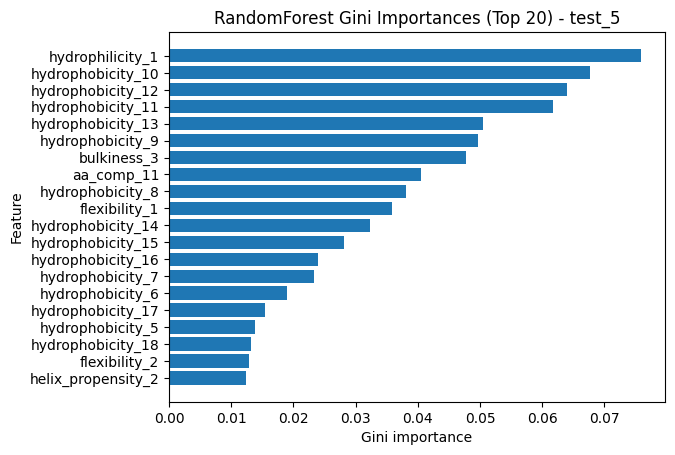

Best k on validation (using baseline best params): k=25, val_acc=0.973


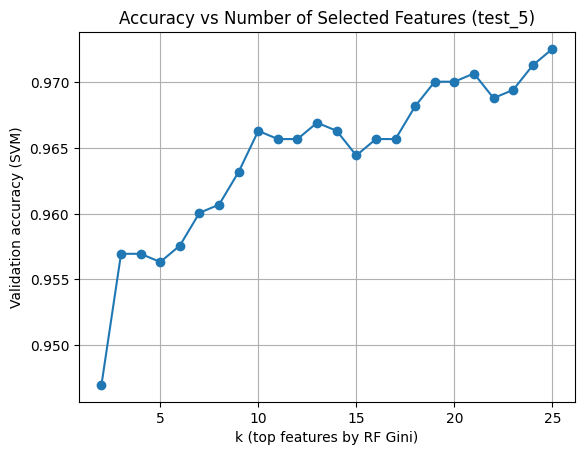


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.976
   → Found with parameters: C = 1.0, gamma = 0.1

Final test accuracy (using selected features): 0.974
Final test accuracy (using all features - baseline model): 0.978

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.869 | ACC = 0.974 | PPV = 0.881 | SEN = 0.886
Confusion Matrix:
 [[1408   21]
 [  20  155]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.886 | ACC = 0.978 | PPV = 0.912 | SEN = 0.886
Confusion Matrix:
 [[1414   15]
 [  20  155]]
               Model       MCC       ACC       PPV       SEN
0  Selected features  0.868845  0.974439  0.880682  0.885714
1       All features  0.886446  0.978180  0.911765  0.885714


In [24]:
results = []
# Define search grids for SVM hyperparameters C and gamma.
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

all_metric_sel = []
all_metric_all = []

# Each iteration corresponds to one cross-validation fold.
# For each fold, we define TRAIN, VALIDATION, and TEST sets based on validation_n values.
for name, (train_idx, val_idx, test_idx) in groups.items():
    print(f"\n=== {name.upper()} ===")
    print(f"Train: {train_idx}, Val: {val_idx}, Test: {test_idx}")

    # Filter the main dataset (X and y) according to the fold indices.
    # Drop non-numerical or identifier columns such as 'id' and 'validation_n'.
    X_train = X[X["validation_n"].isin(train_idx)].drop(columns=["id", "validation_n"])
    X_val   = X[X["validation_n"].isin([val_idx])].drop(columns=["id", "validation_n"])
    X_test  = X[X["validation_n"].isin([test_idx])].drop(columns=["id", "validation_n"])

    y_train = y[complete_train["validation_n"].isin(train_idx)]
    y_val   = y[complete_train["validation_n"].isin([val_idx])]
    y_test  = y[complete_train["validation_n"].isin([test_idx])]

    # Convert the DataFrames into NumPy arrays and save them in a single .npz file.
    # This stores all matrices for the current fold (train, validation, test) in one place.

    X_train_np = X_train.to_numpy()
    X_val_np = X_val.to_numpy()
    X_test_np = X_test.to_numpy()

    y_train_np = y_train.to_numpy()
    y_val_np = y_val.to_numpy()
    y_test_np = y_test.to_numpy()

    np.savez(
        f"cv_set_{name}.npz",
        X_train=X_train_np,
        X_val=X_val_np,
        X_test=X_test_np,
        y_train=y_train_np,
        y_val=y_val_np,
        y_test=y_test_np
    )

    # Perform a manual grid search over C and gamma values.
    # Evaluate each model on the VALIDATION set and store the best parameters.

    best_score_base, best_params_base = grid_search(
    C_grid, gamma_grid,
    X_train.to_numpy(), y_train.to_numpy(),
    X_val.to_numpy(), y_val.to_numpy())
    print( f"{best_score_base:.3f} with params {best_params_base}")


    # Train a Random Forest classifier on the training data.
    # Use the Gini importance to rank features by their predictive power.
    rf = RandomForestClassifier(n_estimators=400,random_state=42,n_jobs=-1)
    rf.fit(X_train, y_train)

    gini_imp = pd.Series(rf.feature_importances_, index=list(data.keys())).sort_values(ascending=False)
    gini_df = gini_imp.reset_index()
    gini_df.columns = ["feature", "importance"]
    print("Top 10 features by Gini importance:")
    print(gini_df.head(10))

    # Visualize the 20 most important features as determined by the Random Forest.
    # Save the figure for documentation of this fold.
    plt.figure()
    plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
    plt.xlabel("Gini importance")
    plt.ylabel("Feature")
    plt.title(f"RandomForest Gini Importances (Top 20) - {name}")
    plt.savefig(f"gini_importances_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Test multiple subsets of top-k features ranked by Gini importance.
    # For each subset size, evaluate the validation accuracy of the baseline SVM.
    ks = list(range(2, min(26, X_train.shape[1]+1)))  # keep it small for speed/clarity
    curve = []

    for k in ks:
        subset = gini_df["feature"].head(k).tolist()
        acc_k = accuracy_on_subset(best_params_base["C"], best_params_base["gamma"], subset)
        curve.append(acc_k)

    best_k_idx = int(np.argmax(curve))
    best_k = ks[best_k_idx]
    print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

    # Visualize how validation accuracy changes with different numbers of features.
    # The best k will correspond to the peak of the curve.
    plt.figure()
    plt.plot(ks, curve, marker="o")
    plt.xlabel("k (top features by RF Gini)")
    plt.ylabel("Validation accuracy (SVM)")
    plt.title(f"Accuracy vs Number of Selected Features ({name})")
    plt.grid(True)
    plt.savefig(f"accuracy_vs_features_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()


    # Keep only the best_k features and re-run the grid search to find new optimal parameters.
    best_subset = gini_df["feature"].head(best_k).tolist()
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in best_subset]

    Xtr_sel = X_train.iloc[:, idx]
    Xva_sel = X_val.iloc[:, idx]
    Xte_sel = X_test.iloc[:, idx]

    best_score_sel, best_params_sel = grid_search(
    C_grid, gamma_grid,
    Xtr_sel.to_numpy(), y_train.to_numpy(),
    Xva_sel.to_numpy(), y_val.to_numpy())
    final_pipe = svm_pipeline(best_params_sel["C"], best_params_sel["gamma"])
    final_pipe.fit(Xtr_sel.to_numpy(), y_train.to_numpy())
    test_acc = final_pipe.score(Xte_sel.to_numpy(), y_test.to_numpy())

    # For comparison: test accuracy with all features using baseline best params
    baseline_pipe = svm_pipeline(best_params_base["C"], best_params_base["gamma"])
    baseline_pipe.fit(X_train.to_numpy(), y_train.to_numpy())
    test_acc_all = baseline_pipe.score(X_test.to_numpy(), y_test.to_numpy())


    print("\n--- RESULTS SUMMARY ---")
    print(f"Best validation accuracy (after feature selection): {best_score_sel:.3f}")
    print(f"   → Found with parameters: C = {best_params_sel['C']}, gamma = {best_params_sel['gamma']}")

    print(f"\nFinal test accuracy (using selected features): {test_acc:.3f}")
    print(f"Final test accuracy (using all features - baseline model): {test_acc_all:.3f}")

    if test_acc > test_acc_all:
      print("\n The model with feature selection performs slightly better on the test set.")
    elif test_acc == test_acc_all:
      print("\n The model with selected features performs the same as the baseline.")
    else:
      print("\n The baseline model (all features) performs slightly better on the test set.")


    #METRICS
    y_pred_sel = final_pipe.predict(Xte_sel)
    y_pred_all = baseline_pipe.predict(X_test)

    obs_test = y_test

    MCC_sel, ACC_sel, PPV_sel, SEN_sel, CONF_sel = metrics(obs_test, y_pred_sel)
    all_metric_sel.append([MCC_sel, ACC_sel,  PPV_sel, SEN_sel])

    MCC_all, ACC_all, PPV_all, SEN_all, CONF_all = metrics(obs_test, y_pred_all)
    all_metric_all.append([MCC_all, ACC_all, PPV_all, SEN_all])

    print("\n=== SVM with FEATURE SELECTION ===")
    print(f"MCC = {MCC_sel:.3f} | ACC = {ACC_sel:.3f} | PPV = {PPV_sel:.3f} | SEN = {SEN_sel:.3f}")
    print("Confusion Matrix:\n", CONF_sel)

    print("\n=== SVM with ALL FEATURES (BASELINE) ===")
    print(f"MCC = {MCC_all:.3f} | ACC = {ACC_all:.3f} | PPV = {PPV_all:.3f} | SEN = {SEN_all:.3f}")
    print("Confusion Matrix:\n", CONF_all)

    results = pd.DataFrame({
    'Model': ['Selected features', 'All features'],
    'MCC': [MCC_sel, MCC_all],
    'ACC': [ACC_sel, ACC_all],
    'PPV': [PPV_sel, PPV_all],
    'SEN': [SEN_sel, SEN_all]
    })

    print(results)

In [ ]:
#msd for the metric with all the features
arr_all = np.array(all_metric_all)
mean_all = np.mean(arr_all, axis=0)
std_all = np.std(arr_all, axis=0)

#mean and st for the metrics with selected features
arr_sel = np.array(all_metric_sel)
mean_sel = np.mean(arr_sel, axis=0)
std_sel = np.std(arr_sel, axis=0)

print("\n=== FEATURE SELECTION ===")
for name, mean, se in zip(["MCC","ACC","PPV","SEN"], mean_sel, std_sel):
    print(f"{name} = {mean:.3f} ± {se:.3f}")

print("\n=== ALL FEATURES ===")
for name, mean, se in zip(["MCC","ACC","PPV","SEN"], mean_all, std_all):
    print(f"{name} = {mean:.3f} ± {se:.3f}")


#